**Description**: Evaluate Matryoshka vs. Diagonaloss vs. nothing. Conclusion: Matryoshka
at 64 is slightly better.

**Required seutp**: Run on a T4 GPU for free in colab.

In [ ]:
!pip install datasets sentence-transformers

In [1]:
from contextlib import contextmanager
from functools import wraps
import os
from typing import Any, Callable, Dict, List, Optional, Tuple, Union, cast

from datasets import load_dataset
import numpy as np
import matplotlib.pyplot as plt
from sentence_transformers import SentenceTransformer
from sentence_transformers.evaluation import (
    EmbeddingSimilarityEvaluator,
    SimilarityFunction,
)
import torch
from tqdm.auto import tqdm

In [ ]:
plot_filename: str = "plot"
model_names: List[str] = [
    "aladar/distilroberta-base-nli",
    "aladar/distilroberta-base-nli-matryoshka",
    "aladar/distilroberta-base-nli-diagonaloss",
]
DIMENSIONS: List[int] = [768, 512, 256, 128, 64]

In [3]:
# Util to truncate
# Should patch instance, not the class b/c maybe there are other models floating around
# that shouldn't get truncated
@contextmanager
def _monkeypatch_instance_method(obj: Any, method_name: str, new_method: Callable):
    original_method = getattr(obj, method_name)
    # Need to use __get__ when patching instance methods
    # https://stackoverflow.com/a/28127947/18758987
    try:
        setattr(obj, method_name, new_method.__get__(obj, obj.__class__))
        yield
    finally:
        setattr(obj, method_name, original_method.__get__(obj, obj.__class__))


@contextmanager
def truncate_embeddings(model: SentenceTransformer, dim: int):
    """
    In this context, the `model` outputs embeddings truncated at dimension `dim`.

    Parameters
    ----------
    model : SentenceTransformer
        model where `model.encode` outputs a (D,) or (N, D) array or tensor of
        embeddings given text(s)
    dim : int
        dimension to truncate at. So a (N, D) array becomes (N, `dim`)
    """

    original_encode = model.encode

    @wraps(original_encode)
    def encode(self, *args, **kwargs) -> Union[np.ndarray, torch.Tensor]:
        embeddings = original_encode(*args, **kwargs)
        return embeddings[..., :dim]

    with _monkeypatch_instance_method(model, "encode", encode):
        yield


# Dimension plot
def _grouped_barplot_ratios(
    group_name_to_x_to_y: Dict[str, Dict[int, float]], ax: Optional[plt.Axes] = None
) -> plt.Axes:
    # To save a pandas dependency, do from scratch in matplotlib
    if ax is None:
        ax: plt.Axes = plt.subplots()
    # Sort each by x
    group_name_to_x_to_y = {
        group_name: dict(sorted(x_to_y.items(), key=lambda x: x[0]))
        for group_name, x_to_y in group_name_to_x_to_y.items()
    }
    # Check that all x are the same
    xticks = None
    for group_name, x_to_y in group_name_to_x_to_y.items():
        _xticks = x_to_y.keys()
        if xticks is not None and _xticks != xticks:
            raise ValueError(f"{group_name} has different keys: {_xticks}")
        xticks = _xticks
    xticks = sorted(xticks)

    # Max y will be the denominator in the ratio/fraction
    group_name_to_max_y = {
        group_name: max(x_to_y.values())
        for group_name, x_to_y in group_name_to_x_to_y.items()
    }
    num_groups = len(group_name_to_x_to_y)
    bar_width = np.diff(xticks).min() / (num_groups + 1)
    # bar_width is the solution to this equation:
    # Say we have the closest x1, x2 st x1 < x2, so x2 - x1 = np.diff(xticks).min().
    # (x2 - (bar_width * num_groups/2)) - (x1 + (bar_width * num_groups/2)) = bar_width
    xs = np.array(
        [
            np.linspace(
                start=xtick - ((bar_width / 2) * (num_groups - 1)),
                stop=xtick + ((bar_width / 2) * (num_groups - 1)),
                num=num_groups,
            )
            for xtick in xticks
        ]
    ).T
    # xs are the center of where the bar goes on the x axis. They have to be manually set
    min_ratio = np.inf
    for i, (group_name, x_to_y) in enumerate(group_name_to_x_to_y.items()):
        max_y = group_name_to_max_y[group_name]
        ys = [y / max_y for y in x_to_y.values()]
        min_ratio = min(min_ratio, min(ys))
        ax.bar(xs[i], ys, bar_width, label=group_name)
    ax.set_xticks(xticks)
    ax.set_xticklabels(xticks)
    ax.grid(linestyle="--")
    ax.set_ylim(min(0.95, min_ratio), 1)
    return ax


def plot_across_dimensions(
    model_name_to_dim_to_score: Dict[str, Dict[int, float]],
    filename: str,
    figsize: Tuple[float, float] = (7, 7),
    title: str = (
        "STSB test score for various embedding dimensions (via truncation),\nwith and "
        "without Matryoshka loss"
    ),
) -> None:
    # Sort each by key
    model_name_to_dim_to_score = {
        model_name: dict(sorted(dim_to_score.items(), key=lambda x: x[0]))
        for model_name, dim_to_score in model_name_to_dim_to_score.items()
    }
    xticks = sorted(list(model_name_to_dim_to_score.values())[0].keys())

    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=figsize)
    ax1 = cast(plt.Axes, ax1)
    ax2 = cast(plt.Axes, ax2)

    # Line plot
    for model_name, dim_to_score in model_name_to_dim_to_score.items():
        ax1.plot(dim_to_score.keys(), dim_to_score.values(), label=model_name)
    ax1.set_xticks(xticks)
    ax1.set_ylabel("Spearman correlation")
    ax1.grid(linestyle="--")
    ax1.legend()

    # Bar plot
    ax2 = _grouped_barplot_ratios(model_name_to_dim_to_score, ax=ax2)
    ax2.set_xlabel("Embedding dimension")
    ax2.set_ylabel("Ratio of maximum performance")

    fig.suptitle(title)
    fig.savefig(filename)

In [6]:
# Load STSb
stsb_test = load_dataset("mteb/stsbenchmark-sts", split="test")
test_evaluator = EmbeddingSimilarityEvaluator(
    stsb_test["sentence1"],
    stsb_test["sentence2"],
    [score / 5 for score in stsb_test["score"]],
    main_similarity=SimilarityFunction.COSINE,
    name="sts-test",
)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Generating train split: 0 examples [00:00, ? examples/s]

Generating validation split: 0 examples [00:00, ? examples/s]

Generating test split: 0 examples [00:00, ? examples/s]

In [7]:
# Run test_evaluator
model_name_to_dim_to_score: Dict[str, Dict[int, float]] = {}
for model_name in tqdm(model_names, desc="Evaluating models"):
    model = SentenceTransformer(model_name)
    dim_to_score: Dict[int, float] = {}
    for dim in tqdm(DIMENSIONS, desc=f"Evaluating {model_name}"):
        output_path = os.path.join(model_name, f"dim-{dim}")
        os.makedirs(output_path)
        with truncate_embeddings(model, dim):
            score = test_evaluator(model, output_path=output_path)
        print(f"Saved results to {output_path}")
        dim_to_score[dim] = score
    model_name_to_dim_to_score[model_name] = dim_to_score

Evaluating models:   0%|          | 0/3 [00:00<?, ?it/s]

modules.json:   0%|          | 0.00/229 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/171 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/4.03k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/52.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/671 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/328M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/1.22k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/798k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.11M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/280 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/296 [00:00<?, ?B/s]

Evaluating aladar/distilroberta-base-nli:   0%|          | 0/5 [00:00<?, ?it/s]

Saved results to aladar/distilroberta-base-nli/dim-768
Saved results to aladar/distilroberta-base-nli/dim-512
Saved results to aladar/distilroberta-base-nli/dim-256
Saved results to aladar/distilroberta-base-nli/dim-128
Saved results to aladar/distilroberta-base-nli/dim-64


modules.json:   0%|          | 0.00/229 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/171 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/4.16k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/52.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/671 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/328M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/1.22k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/798k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.11M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/280 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/296 [00:00<?, ?B/s]

Evaluating aladar/distilroberta-base-nli-matryoshka:   0%|          | 0/5 [00:00<?, ?it/s]

Saved results to aladar/distilroberta-base-nli-matryoshka/dim-768
Saved results to aladar/distilroberta-base-nli-matryoshka/dim-512
Saved results to aladar/distilroberta-base-nli-matryoshka/dim-256
Saved results to aladar/distilroberta-base-nli-matryoshka/dim-128
Saved results to aladar/distilroberta-base-nli-matryoshka/dim-64


modules.json:   0%|          | 0.00/229 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/171 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/4.10k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/52.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/671 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/328M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/1.22k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/798k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.11M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/280 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/296 [00:00<?, ?B/s]

Evaluating aladar/distilroberta-base-nli-diagonaloss:   0%|          | 0/5 [00:00<?, ?it/s]

Saved results to aladar/distilroberta-base-nli-diagonaloss/dim-768
Saved results to aladar/distilroberta-base-nli-diagonaloss/dim-512
Saved results to aladar/distilroberta-base-nli-diagonaloss/dim-256
Saved results to aladar/distilroberta-base-nli-diagonaloss/dim-128
Saved results to aladar/distilroberta-base-nli-diagonaloss/dim-64


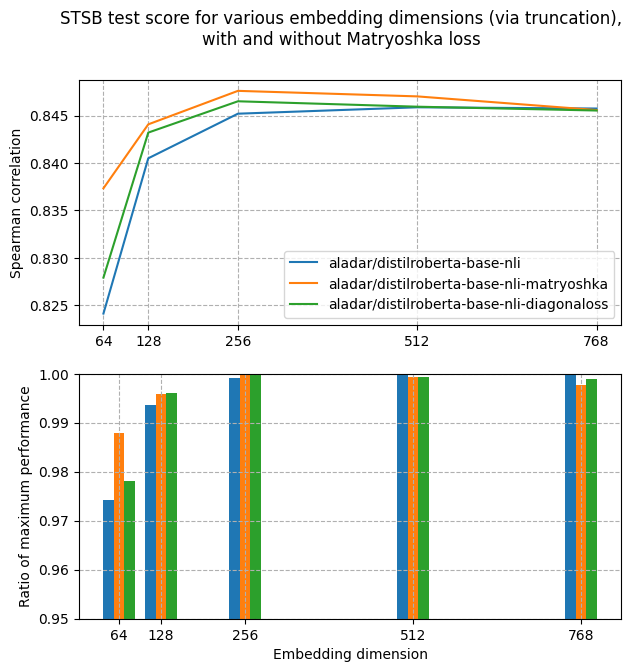

In [8]:
# Save plot
plot_across_dimensions(model_name_to_dim_to_score, plot_filename)